In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
def load_dataset(src_path, data):
  folders = os.listdir(src_path)
  folders.sort()
  
  for folder in folders:
    images = os.listdir(os.path.join(src_path, folder))
    images.sort()
    print("Load {} images from class '{}' in progress...".format(len(images), folder))
    
    for image in tqdm(images):
      label = folder
      try:
        img = cv2.imread(os.path.join(src_path, folder, image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224), cv2.INTER_AREA)
      except:
        continue
      
      data.append([np.array(img), np.array(label)])
    print()
  
  random.shuffle(data)
  return data

In [ ]:
dataset = []
src_path = '/content/drive/My Drive/TA/TA - Kopi/Dataset/original/original_aug_1'
dataset = load_dataset(src_path, dataset)

Load 780 images from class 'healthy' in progress...


100%|██████████| 780/780 [00:25<00:00, 30.81it/s] 



Load 760 images from class 'red_spider_mite' in progress...


100%|██████████| 760/760 [00:16<00:00, 47.01it/s] 



Load 873 images from class 'rust_level_1' in progress...


100%|██████████| 873/873 [00:09<00:00, 95.91it/s] 



Load 840 images from class 'rust_level_2' in progress...


100%|██████████| 840/840 [00:22<00:00, 37.12it/s] 



Load 816 images from class 'rust_level_3' in progress...


100%|██████████| 816/816 [00:08<00:00, 93.40it/s] 



Load 800 images from class 'rust_level_4' in progress...


100%|██████████| 800/800 [00:07<00:00, 100.49it/s]

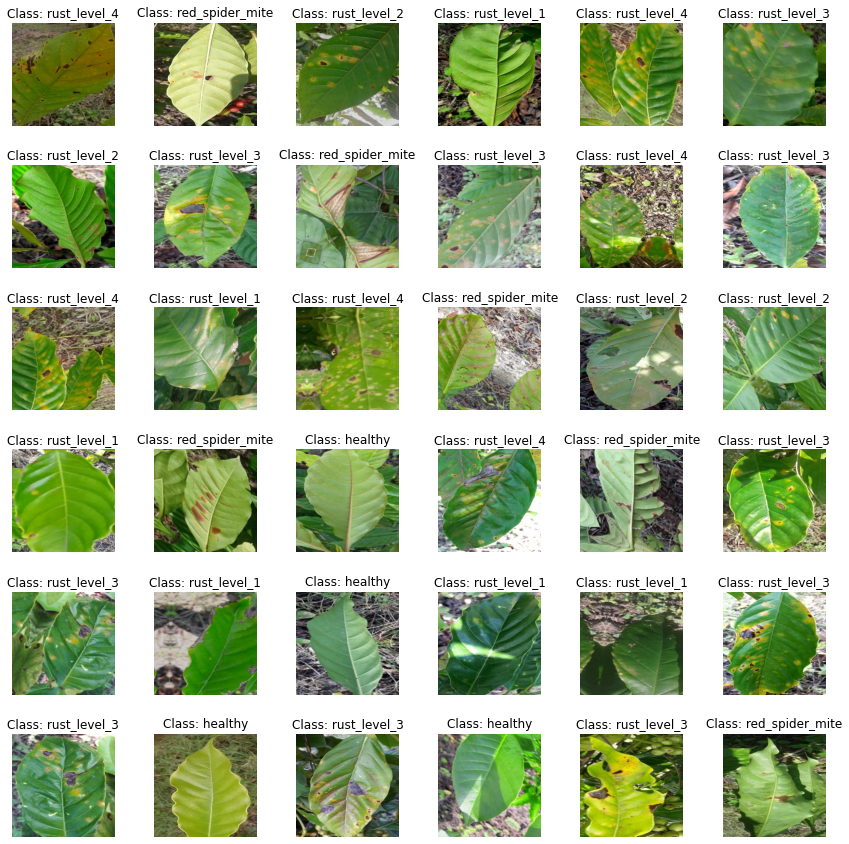

In [ ]:
fig, ax = plt.subplots(6,6)
fig.set_size_inches(12,12)
for i in range(6):
  for j in range (6):
    sample = random.choice(range(len(dataset)))
    ax[i,j].imshow(dataset[sample][0])
    ax[i,j].set_title('Class: '+str(dataset[sample][1]))
    ax[i,j].axis('off')
plt.tight_layout()

## Split Dataset

In [ ]:
X = np.array([i[0] for i in dataset]).reshape(-1,224,224,3)
y = np.array([i[1] for i in dataset])

In [ ]:
labels = {'healthy':0, 'red_spider_mite':1, 'rust_level_1':2, 'rust_level_2':3, 'rust_level_3':4, 'rust_level_4':5}
y = np.vectorize(labels.get)(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

test_sample = X_test.copy()

print('Training size\t: X = {}\ty = {}'.format(len(X_train), len(y_train)))
print('Validation size\t: X = {}\ty = {}'.format(len(X_val), len(y_val)))
print('Testing size\t: X = {}\ty = {}'.format(len(X_test), len(y_test)))

Training size	: X = 3517	y = 3517
Validation size	: X = 621	y = 621
Testing size	: X = 731	y = 731


# Classification

## Build Model

In [ ]:
def freeze_model(model, base_model):
  for layer in base_model.layers:
    layer.trainable = False

def unfreeze_model(model):
  for layer in model.layers[-20:]:
    layer.trainable = True
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
base = EfficientNetB0(include_top=False, weights='imagenet', classes=6, input_shape=(224,224,3), classifier_activation='softmax')
top = GlobalAveragePooling2D()(base.output)
top = BatchNormalization()(top)
top = Dropout(0.2)(top)
outputs = Dense(6, activation='softmax')(top)
model = Model(inputs=base.input, outputs=outputs)

freeze_model(model, base)
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

## Train Model

In [ ]:
def plot_training_history(history):
  plt.style.use('ggplot')
  fig = plt.figure(figsize=(12,6))
  
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(train_acc))
  
  plt.subplot(1,2,1)
  plt.plot(epochs, val_acc)
  plt.plot(epochs, train_acc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(['Validation Accuracy','Training Accuracy'], loc='lower right')
  
  plt.subplot(1,2,2)
  plt.plot(epochs, val_loss)
  plt.plot(epochs, train_loss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend(['Validation Loss','Training Loss'], loc='upper right')
  plt.show()

### Fine-Tuning

In [ ]:
unfreeze_model(model)

for layer in model.layers:
  print('{}: {}'.format(layer.name, layer.trainable))

input_1: False
rescaling: False
normalization: False
stem_conv_pad: False
stem_conv: False
stem_bn: False
stem_activation: False
block1a_dwconv: False
block1a_bn: False
block1a_activation: False
block1a_se_squeeze: False
block1a_se_reshape: False
block1a_se_reduce: False
block1a_se_expand: False
block1a_se_excite: False
block1a_project_conv: False
block1a_project_bn: False
block2a_expand_conv: False
block2a_expand_bn: False
block2a_expand_activation: False
block2a_dwconv_pad: False
block2a_dwconv: False
block2a_bn: False
block2a_activation: False
block2a_se_squeeze: False
block2a_se_reshape: False
block2a_se_reduce: False
block2a_se_expand: False
block2a_se_excite: False
block2a_project_conv: False
block2a_project_bn: False
block2b_expand_conv: False
block2b_expand_bn: False
block2b_expand_activation: False
block2b_dwconv: False
block2b_bn: False
block2b_activation: False
block2b_se_squeeze: False
block2b_se_reshape: False
block2b_se_reduce: False
block2b_se_expand: False
block2b_se_ex

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val))

Epoch 1/50
55/55 [==============================] - 29s 205ms/step - loss: 1.5972 - accuracy: 0.5439 - val_loss: 8.2434 - val_accuracy: 0.4348
Epoch 2/50
55/55 [==============================] - 7s 134ms/step - loss: 0.8002 - accuracy: 0.7140 - val_loss: 2.2253 - val_accuracy: 0.6216
Epoch 3/50
55/55 [==============================] - 7s 135ms/step - loss: 0.5333 - accuracy: 0.8049 - val_loss: 2.7854 - val_accuracy: 0.5539
Epoch 4/50
55/55 [==============================] - 7s 135ms/step - loss: 0.4154 - accuracy: 0.8473 - val_loss: 1.6764 - val_accuracy: 0.6570
Epoch 5/50
55/55 [==============================] - 7s 135ms/step - loss: 0.4476 - accuracy: 0.8536 - val_loss: 9.6184 - val_accuracy: 0.6216
Epoch 6/50
55/55 [==============================] - 7s 136ms/step - loss: 0.3611 - accuracy: 0.8789 - val_loss: 2.1474 - val_accuracy: 0.7262
Epoch 7/50
55/55 [==============================] - 7s 136ms/step - loss: 0.3019 - accuracy: 0.9045 - val_loss: 2.1782 - val_accuracy: 0.7585
Epoch

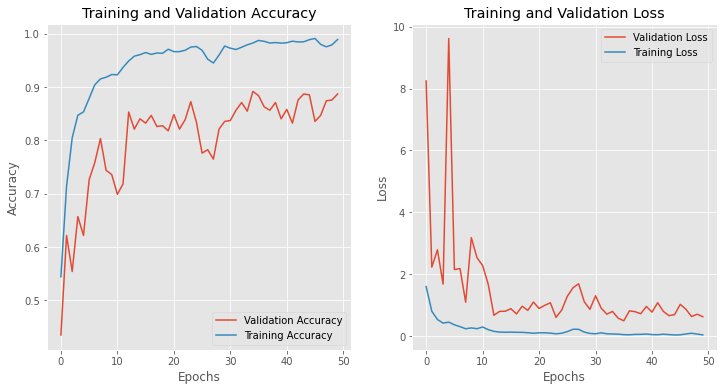

In [ ]:
plot_training_history(history)

In [ ]:
print('Training Evaluation')
loss, acc = model.evaluate(X_train, y_train)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Training Evaluation
110/110 [==============================] - 8s 65ms/step - loss: 0.0056 - accuracy: 0.9977
Loss		: 0.005578665994107723
Accuracy	: 0.9977253079414368


In [ ]:
print('Validation Evaluation')
loss, acc = model.evaluate(X_val, y_val)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Validation Evaluation
20/20 [==============================] - 2s 83ms/step - loss: 0.6225 - accuracy: 0.8873
Loss		: 0.6224683523178101
Accuracy	: 0.8872785568237305


## Test Model

In [ ]:
print('Testing Evaluation')
loss, acc = model.evaluate(X_test, y_test)
print('Loss\t\t:', loss)
print('Accuracy\t:', acc)

Testing Evaluation
23/23 [==============================] - 2s 82ms/step - loss: 0.5555 - accuracy: 0.8988
Loss		: 0.5554810166358948
Accuracy	: 0.8987687826156616


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       117
           1       0.93      0.78      0.85       114
           2       0.76      0.84      0.80       131
           3       0.91      0.92      0.92       126
           4       0.97      0.98      0.97       123
           5       1.00      0.98      0.99       120

    accuracy                           0.90       731
   macro avg       0.90      0.90      0.90       731
weighted avg       0.90      0.90      0.90       731



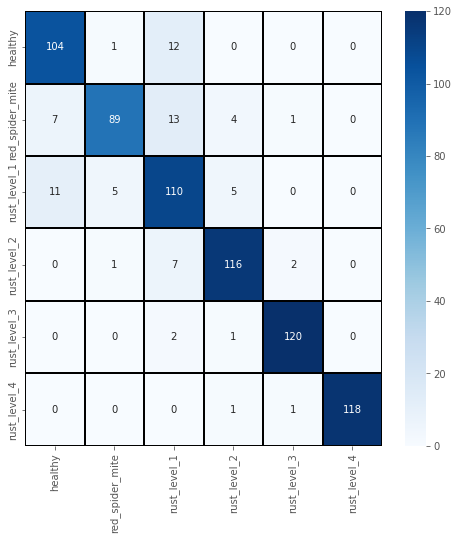

In [ ]:
L = list(labels)
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix = pd.DataFrame(c_matrix, index=L, columns=L)

plt.figure(figsize = (8,8))
sn.heatmap(c_matrix, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=L, yticklabels=L)

In [ ]:
def display_sample(data, y_pred, y_test):
  warnings.filterwarnings('always')
  warnings.filterwarnings('ignore')
  
  if len(data)==0:
    print('Error! No sample found, sample data empty.')
  
  else:
    fig, ax = plt.subplots(4,4)
    fig.set_size_inches(10,10)
    for i in range(4):
      for j in range(4):
        sample = random.choice(range(len(data)))
        ax[i,j].imshow(test_sample[data[sample]])
        ax[i,j].set_title('Predicted: '+str(y_pred[data[sample]])+'\n'+'Actual: '+str(y_test[data[sample]]))
        ax[i,j].axis('off')
    plt.tight_layout()

In [ ]:
labels = {v: k for k, v in labels.items()}
y_pred = np.vectorize(labels.get)(y_pred)
y_test = np.vectorize(labels.get)(y_test)

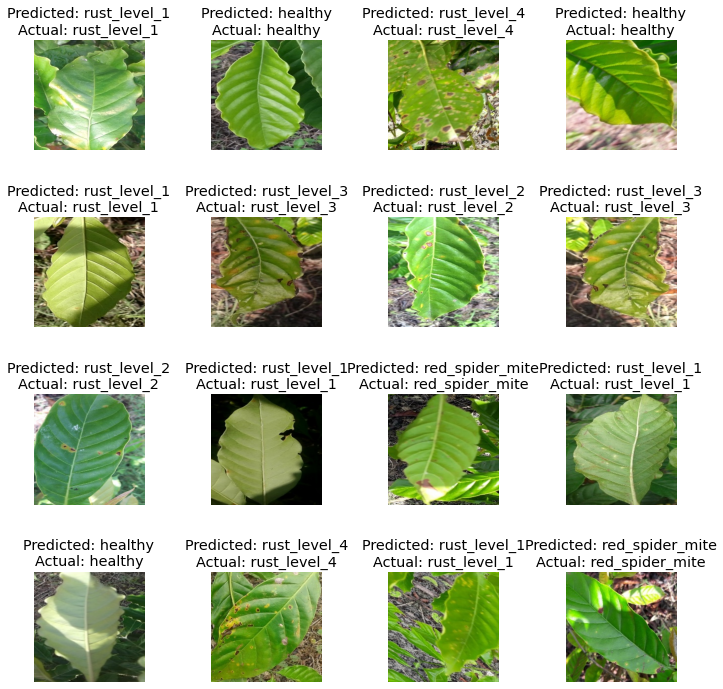

In [ ]:
i = 0
true_data = []
for i in range(len(y_test)):
  if y_test[i]==y_pred[i]:
    true_data.append(i)

display_sample(true_data, y_test, y_pred)

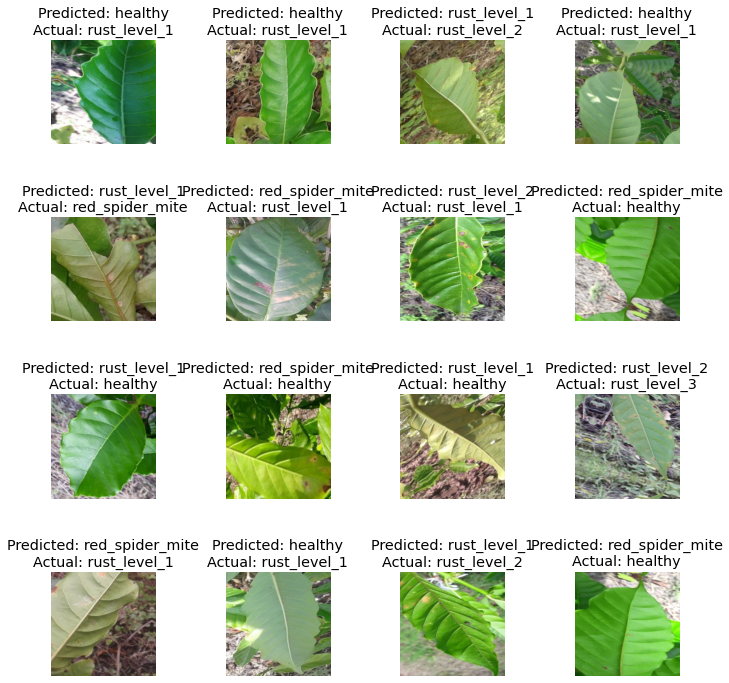

In [ ]:
i = 0
false_data = []
for i in range(len(y_test)):
  if not y_test[i]==y_pred[i]:
    false_data.append(i)

display_sample(false_data, y_test, y_pred)

In [ ]:
del model
K.clear_session()